In [1]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.layers import *
from autoencoder.supervise import equation
from sklearn import preprocessing
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})

## Plotting functions

In [2]:
# plot true and reconstructed Phi
def plot_u(Phi, u):
    """
    Samples 3 data solutions Phi and their corresponding
    reconstructed solutions u from the semantic 
    autoencoder, and plots both Phi and u
    """
    domain = np.linspace(0., 1., 100)
    num_plots = 3
    num_Phi = Phi.shape[0]
    sample_idxs = np.random.randint(0, num_Phi - 1, num_plots)
    
    fig, ax = plt.subplots(1, num_plots, figsize=(20,8), dpi=200)
    for i, s in enumerate(sample_idxs):
        ax[i].plot(domain, Phi[s], linewidth=3)
        ax[i].plot(domain, u[s], linewidth=3)
    fig.legend([r'$\Phi$', r'$u$'])
    plt.show()
    plt.close()

In [3]:
# plot true theta and learned theta
def plot_theta(theta_Phi, theta, transform=True):
    if transform:
        maxabs_theta_Phi = np.max(np.abs(theta_Phi), axis=0)
        maxabs_theta = np.max(np.abs(theta), axis=0)
        theta_Phi = theta_Phi / maxabs_theta_Phi
        theta = theta / maxabs_theta
        
    t_names = [r'$c$', r'$b_0$', r'$b_1$']
    num_plots = theta_Phi.shape[1]
    
    fig, ax = plt.subplots(1, num_plots, 
                           sharey=transform, 
                           figsize=(20,8), 
                           dpi=200)
    for i in range(num_plots):
        ax[i].scatter(theta_Phi[:, i], theta[:, i])
        ax[i].plot([0,1], [0,1], transform=ax[i].transAxes, c='r', lw=3)
        ax[i].set_title(t_names[i])
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor='none', bottom=False, left=False)
    plt.xlabel('Truth')
    plt.ylabel('Prediction', labelpad=50)
    plt.show()
    plt.close()

## Load and preprocess data

In [4]:
# load data
dataset = equation.Dataset('poisson')
dataset.load()
Phi_train, theta_train = dataset.train
Phi_val, theta_val = dataset.validate
Phi_test, theta_test = dataset.test

# maxabs scalers
Phi_train_transformer = preprocessing.MaxAbsScaler()
theta_train_transformer = preprocessing.MaxAbsScaler()
Phi_val_transformer = preprocessing.MaxAbsScaler()
theta_val_transformer = preprocessing.MaxAbsScaler()
Phi_test_transformer = preprocessing.MaxAbsScaler()
theta_test_transformer = preprocessing.MaxAbsScaler()

# rescale data
Phi_train_trans = Phi_train_transformer.fit_transform(Phi_train)
theta_train_trans = theta_train_transformer.fit_transform(theta_train)
Phi_val_trans = Phi_val_transformer.fit_transform(Phi_val)
theta_val_trans = theta_val_transformer.fit_transform(theta_val)
Phi_test_trans = Phi_test_transformer.fit_transform(Phi_test)
theta_test_trans = theta_test_transformer.fit_transform(theta_test)

## Build network

In [5]:
# analytic decoder
def analytic_decoder(theta):
    c, b0, b1 = tf.split(theta, 3, axis=1)
    # x and x^2
    x = np.linspace(0., 1., 100)
    x2 = x ** 2
    # -c/2 x^2
    ux2 = tf.math.divide(c, -2.)
    ux2 = tf.math.multiply(ux2, x2)
    # (c/2 + b1 - b0) x
    ux = tf.math.divide(c, 2.)
    ux = tf.math.add(ux, b1)
    ux = tf.math.subtract(ux, b0)
    ux = tf.math.multiply(ux, x)
    # b0
    u = tf.math.add(ux2, ux)
    u = tf.math.add(u, b0)
    return u

In [6]:
# network parameters
tf.config.experimental_run_functions_eagerly(True)
latent_dim = 3
batch_size = 25
input_shape = (100,)
Phi = Input(shape=input_shape)

In [7]:
# encoder
x = Dense(20, 'tanh', name='hidden')(Phi)
theta = Dense(latent_dim, 'linear', name='theta')(x)
u = Lambda(analytic_decoder, name='u')(theta)

In [8]:
# compile model
sae = tf.keras.Model(Phi, u)
sae.compile('adam', 'mse')
sae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
hidden (Dense)               (None, 20)                2020      
_________________________________________________________________
theta (Dense)                (None, 3)                 63        
_________________________________________________________________
u (Lambda)                   (None, 100)               0         
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________


## Train and evaluate

In [22]:
# fit model
set_seed(23) # for reproducibility
sae.fit(x=Phi_train_trans, y=Phi_train_trans, 
        validation_data=(Phi_val_trans, Phi_val_trans),
        epochs=60, 
        batch_size=batch_size, 
        verbose=2)

Epoch 1/60
48/48 - 0s - loss: 0.0029 - val_loss: 0.0025
Epoch 2/60
48/48 - 0s - loss: 0.0026 - val_loss: 0.0023
Epoch 3/60
48/48 - 0s - loss: 0.0025 - val_loss: 0.0022
Epoch 4/60
48/48 - 0s - loss: 0.0024 - val_loss: 0.0021
Epoch 5/60
48/48 - 0s - loss: 0.0023 - val_loss: 0.0021
Epoch 6/60
48/48 - 0s - loss: 0.0023 - val_loss: 0.0020
Epoch 7/60
48/48 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 8/60
48/48 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 9/60
48/48 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 10/60
48/48 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 11/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 12/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 13/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 14/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 15/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 16/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 17/60
48/48 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 18/60
48/48 - 0s - loss: 0.0020 - 

In [10]:
print(sae.evaluate(Phi_test, Phi_test, verbose=0))
print(sae.evaluate(Phi_val_trans, Phi_val_trans, verbose=0))

0.0007060552597977221
0.002743952674791217


## Plots

In [23]:
# extract theta estimates
get_theta = tf.keras.Model(sae.input, sae.get_layer('theta').output)
theta_test_hat = get_theta(Phi_test).numpy()

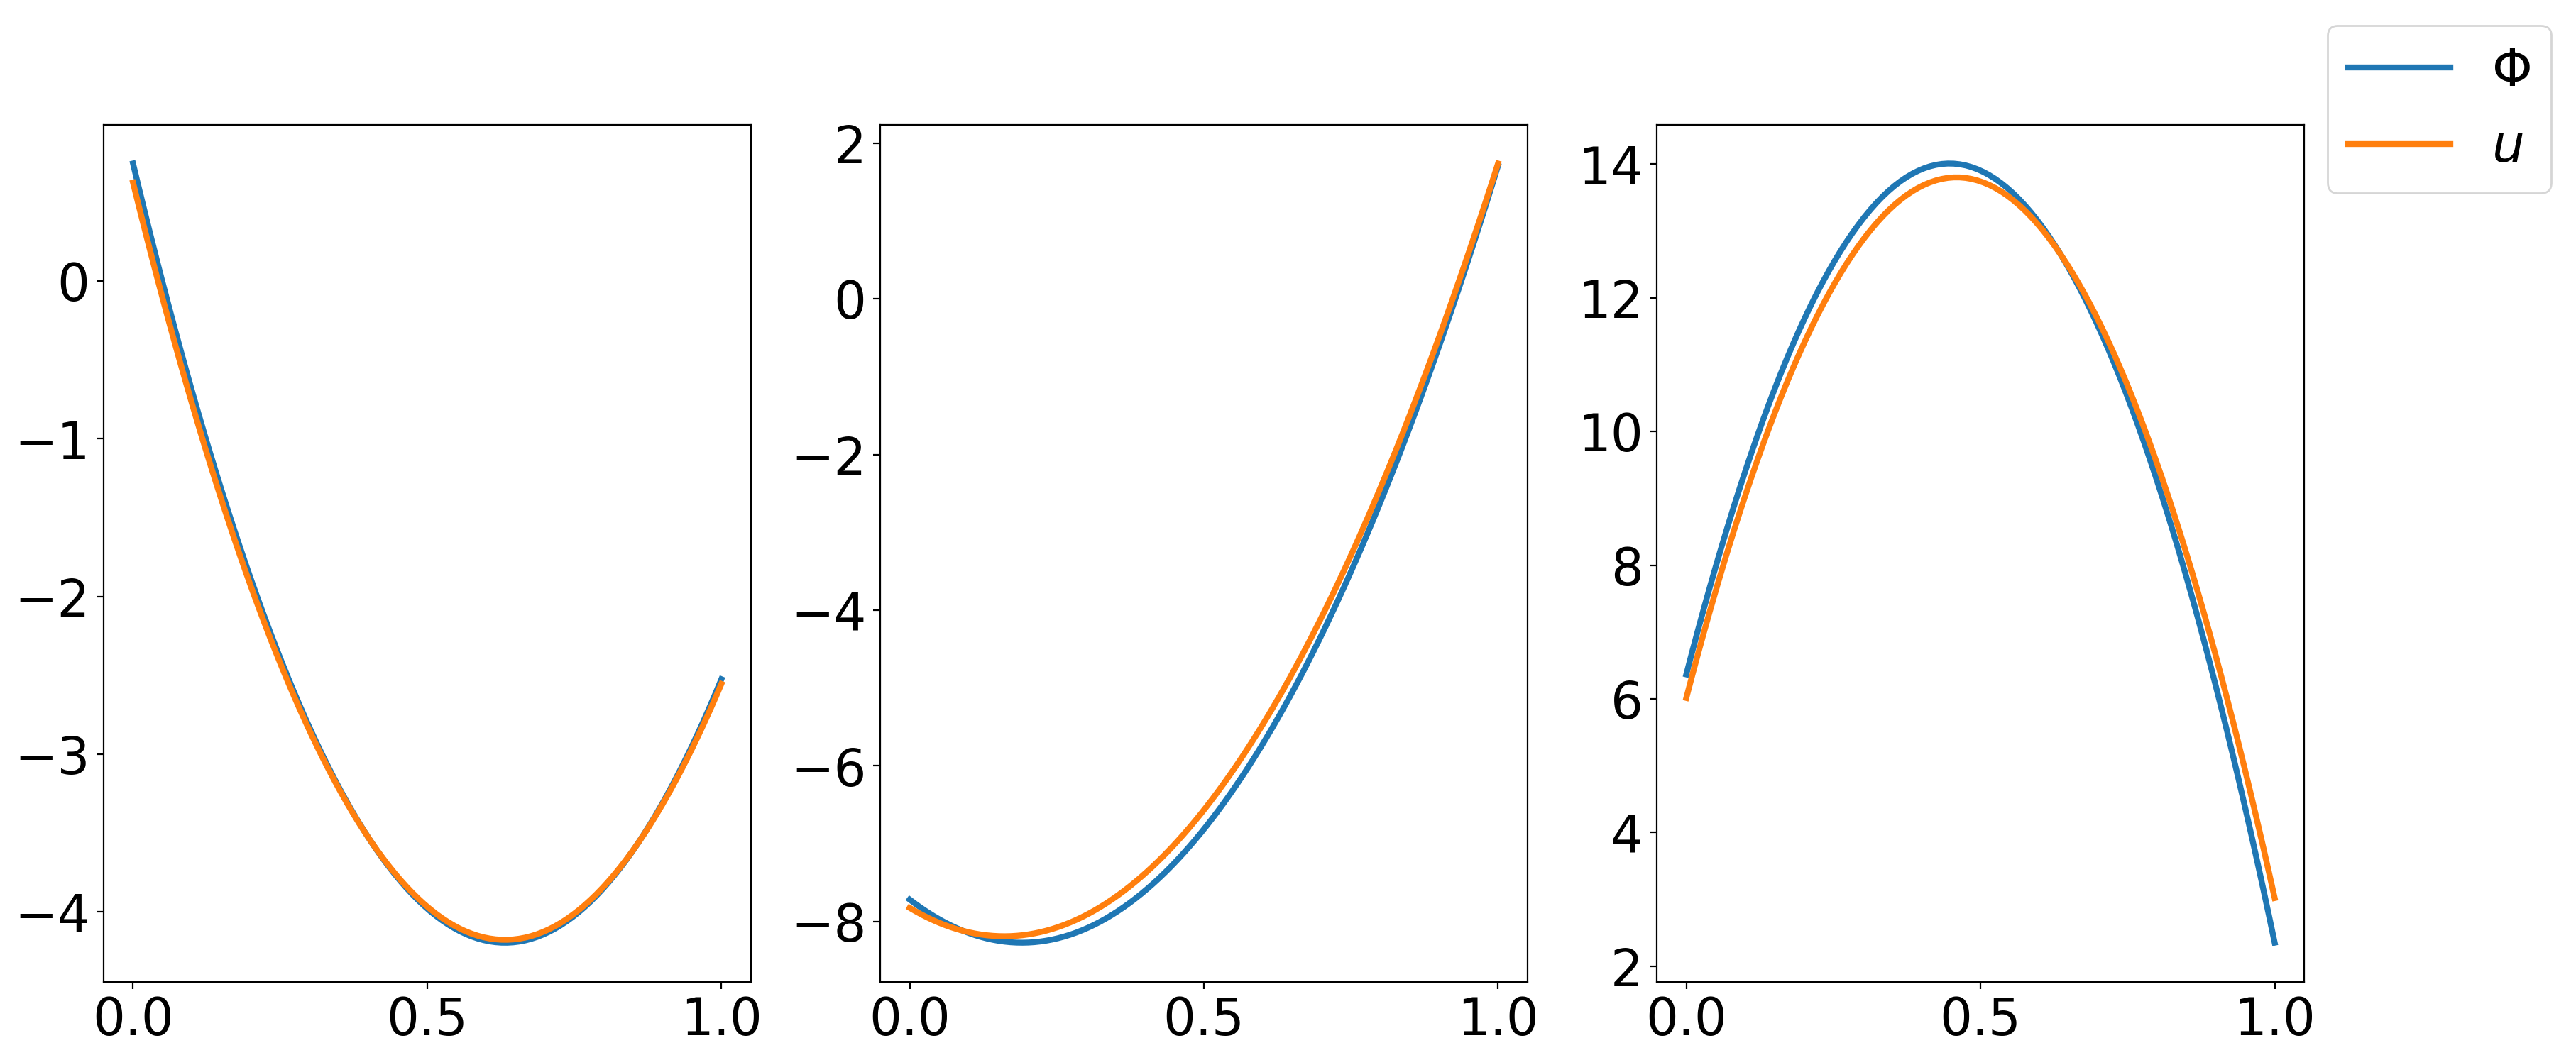

In [26]:
# validation set plots
Phi_test_hat = sae.predict(Phi_test_trans)
plot_u(Phi_test, Phi_test_hat)

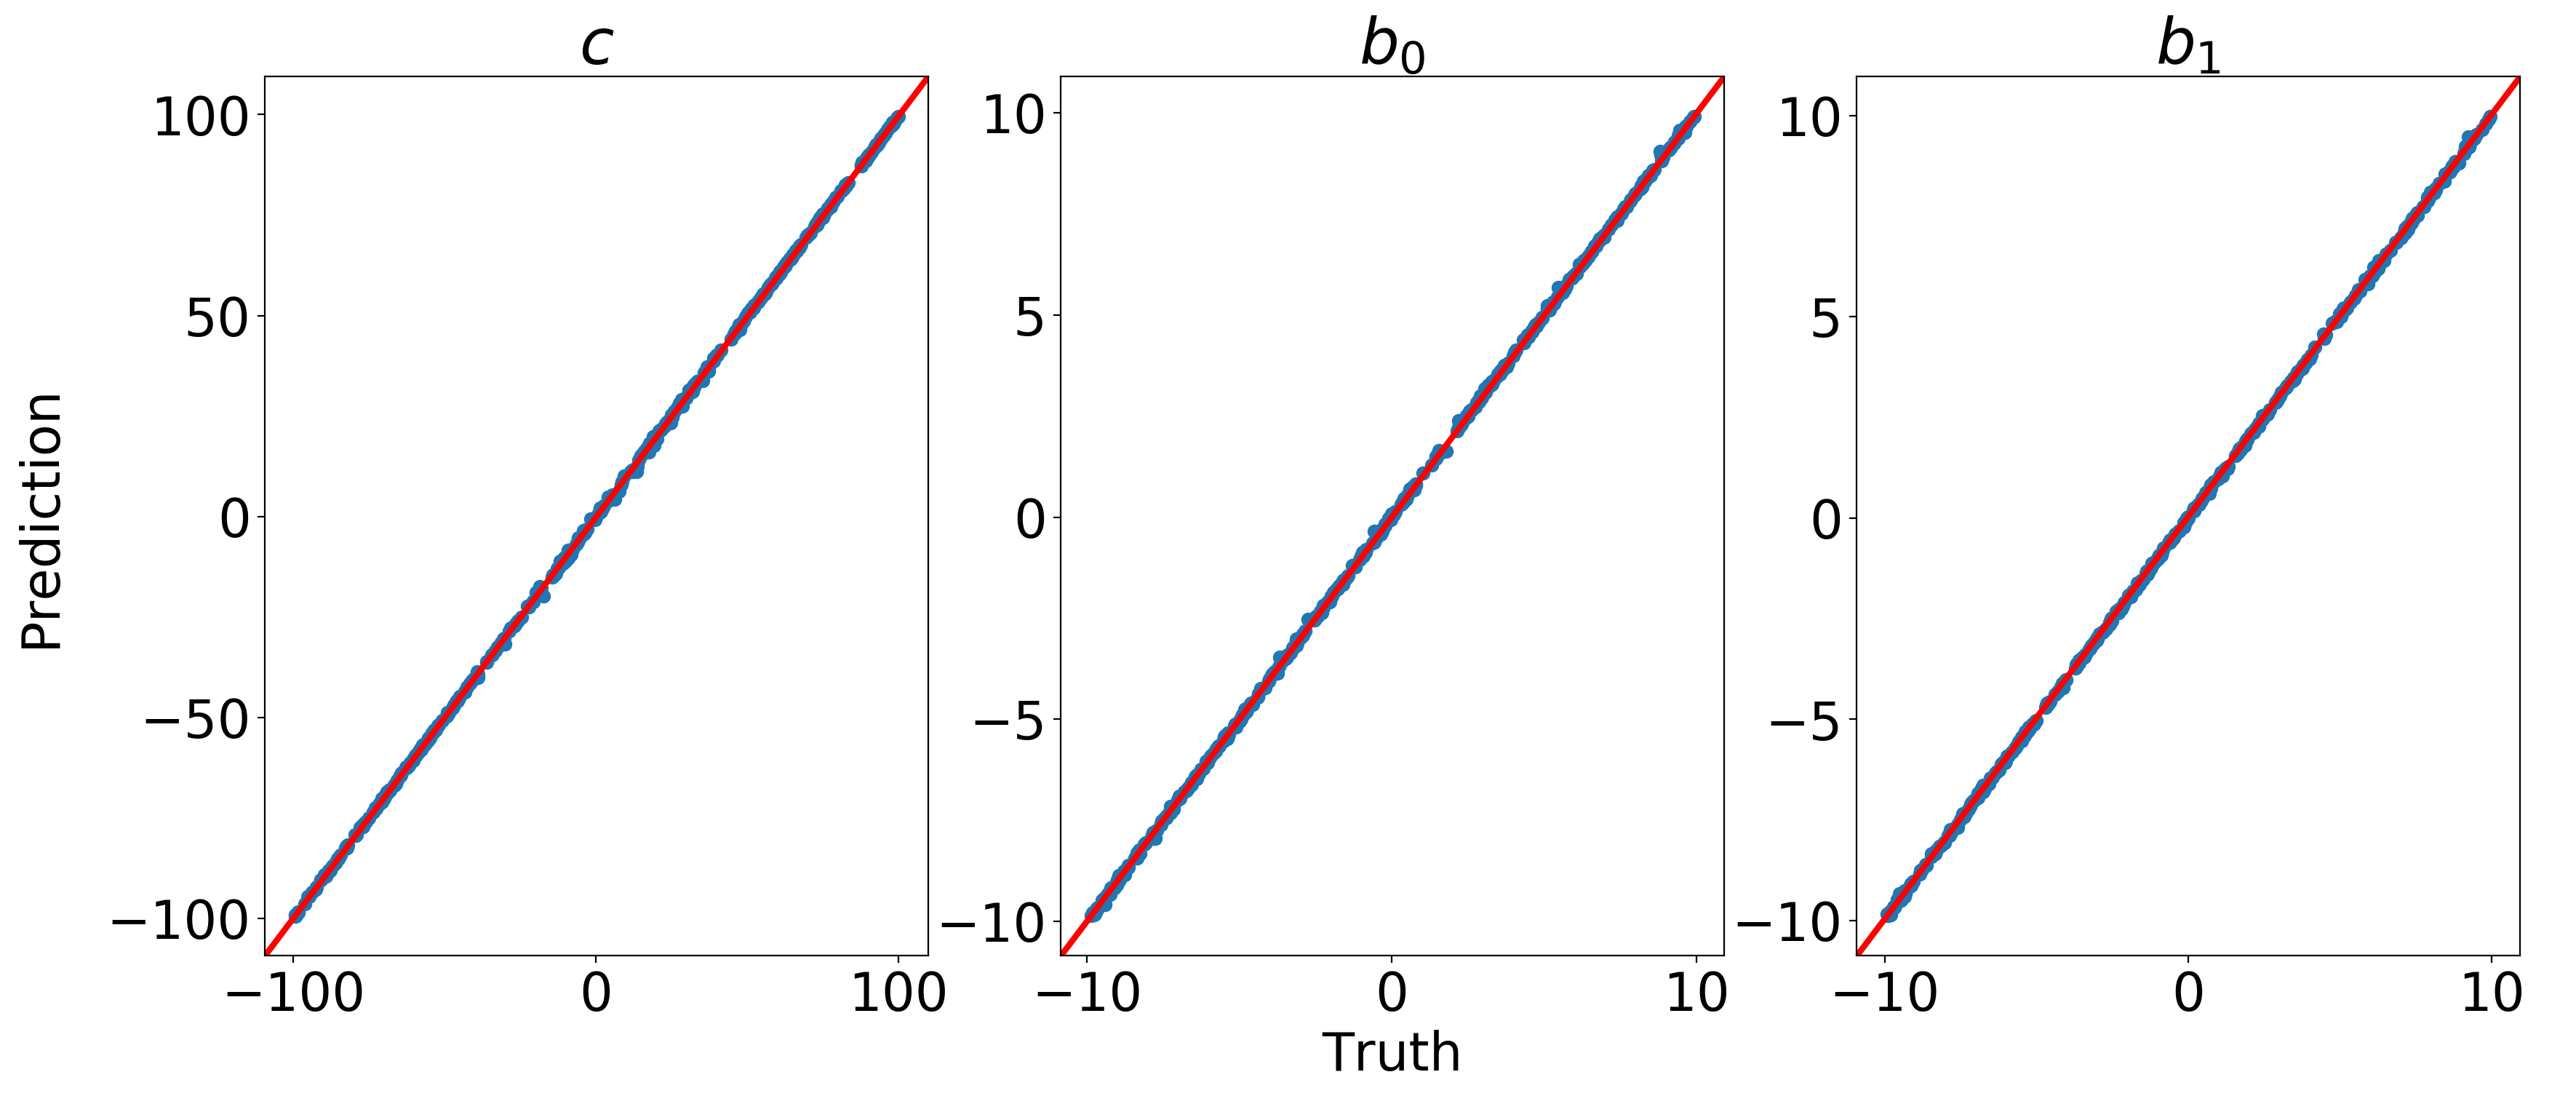

In [21]:
plot_theta(theta_test, theta_test_hat, transform=False)

## Testing robustness

In [14]:
epsilon = np.random.randn(Phi_test.size).reshape(400, 100)
Phi_test_noisy = Phi_test + 0.5 * epsilon
print(sae.evaluate(Phi_test_noisy, Phi_test_noisy, verbose=0))
Phi_test_noisy_hat = sae.predict(Phi_test_noisy)
theta_test_noisy_hat = get_theta(Phi_test_noisy).numpy()

0.4226076900959015


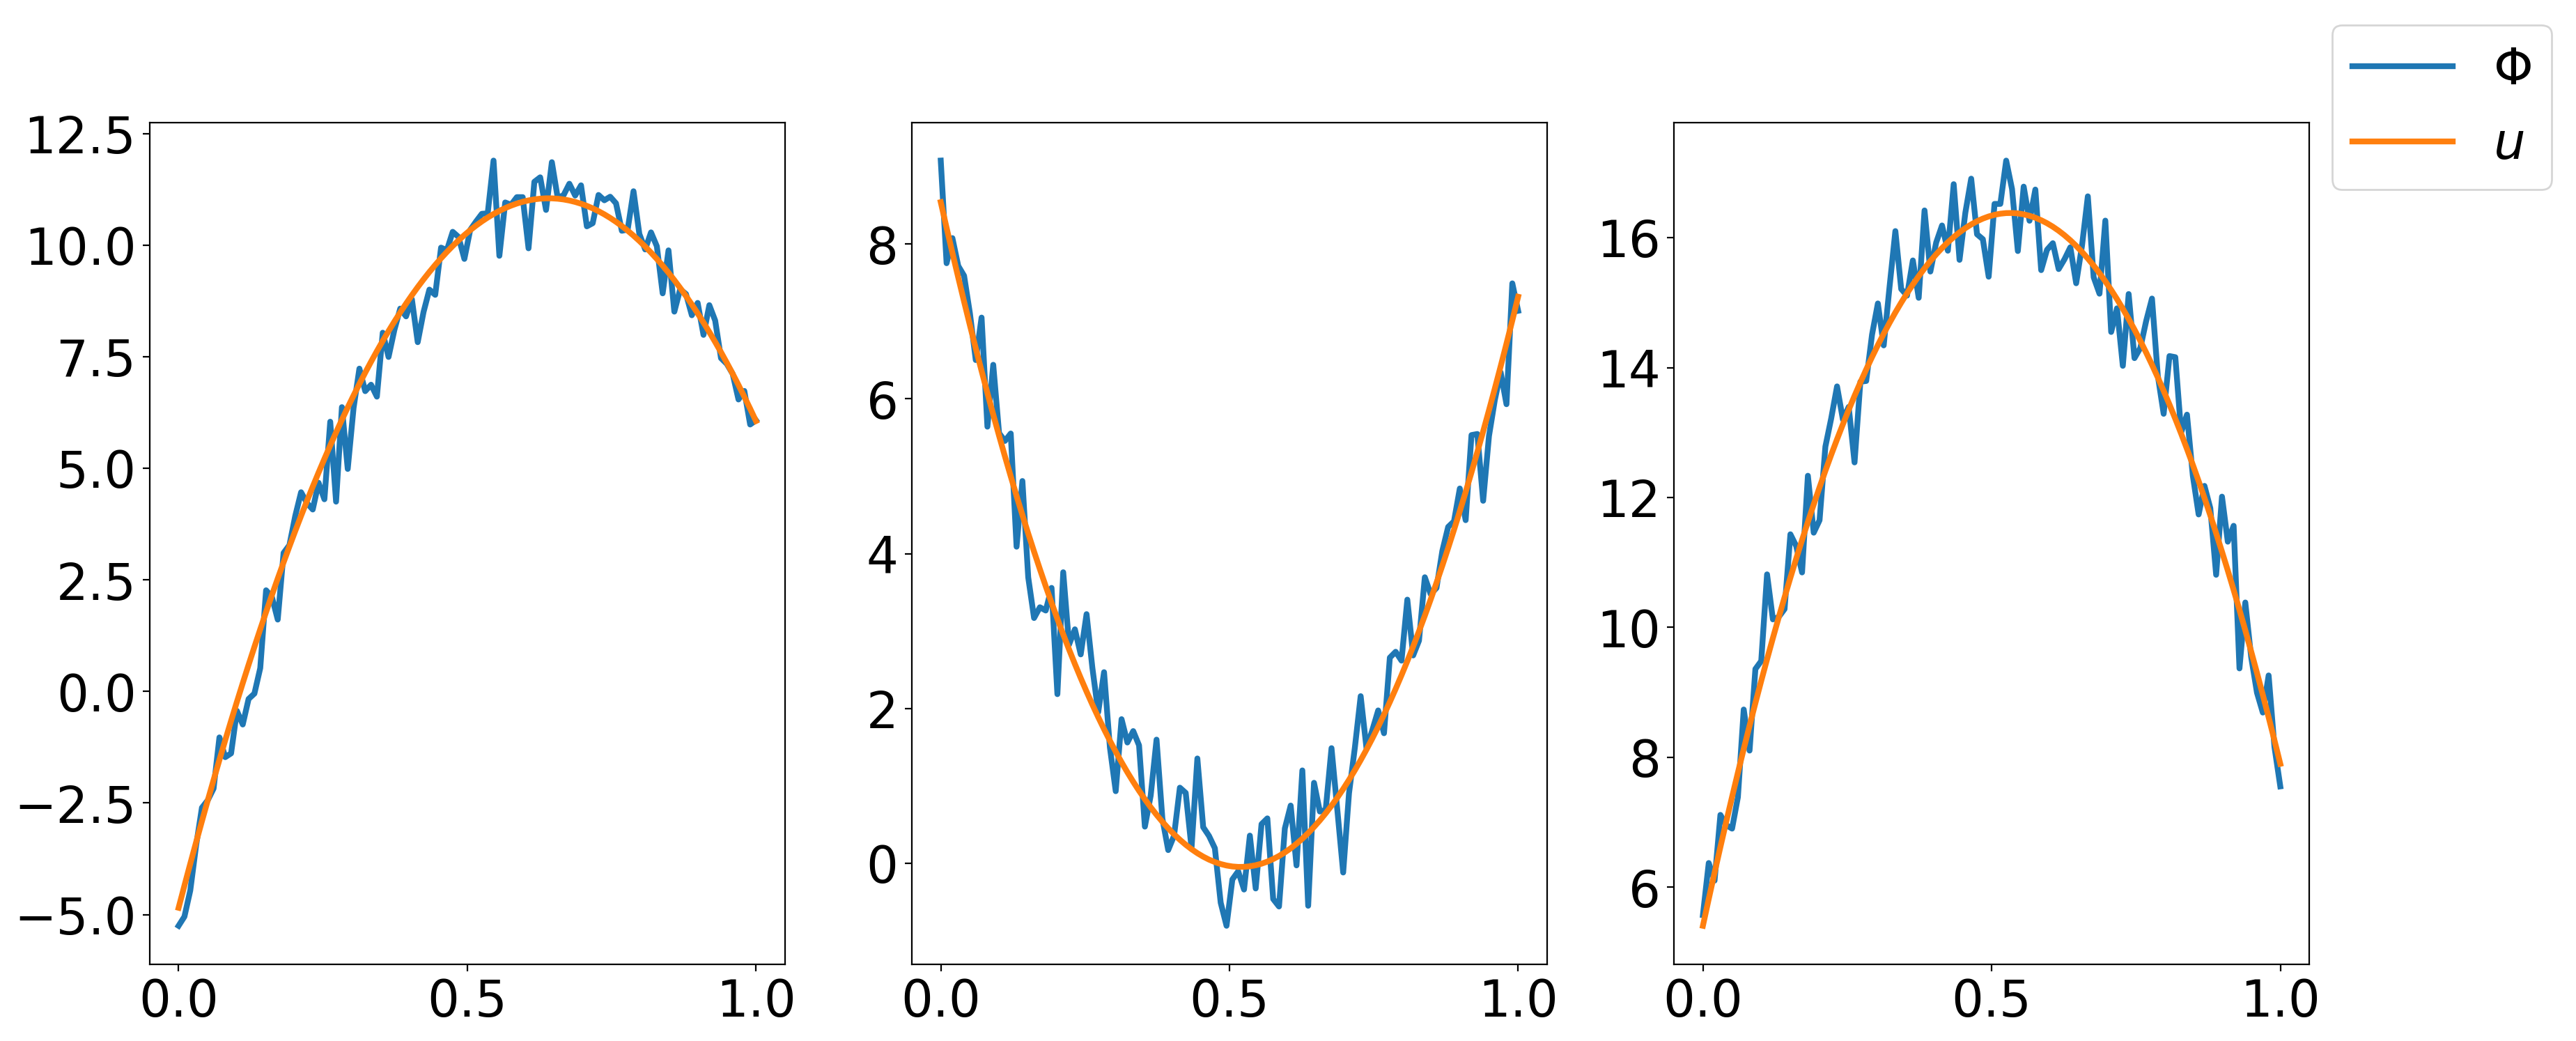

In [15]:
plot_u(Phi_test_noisy, Phi_test_noisy_hat)

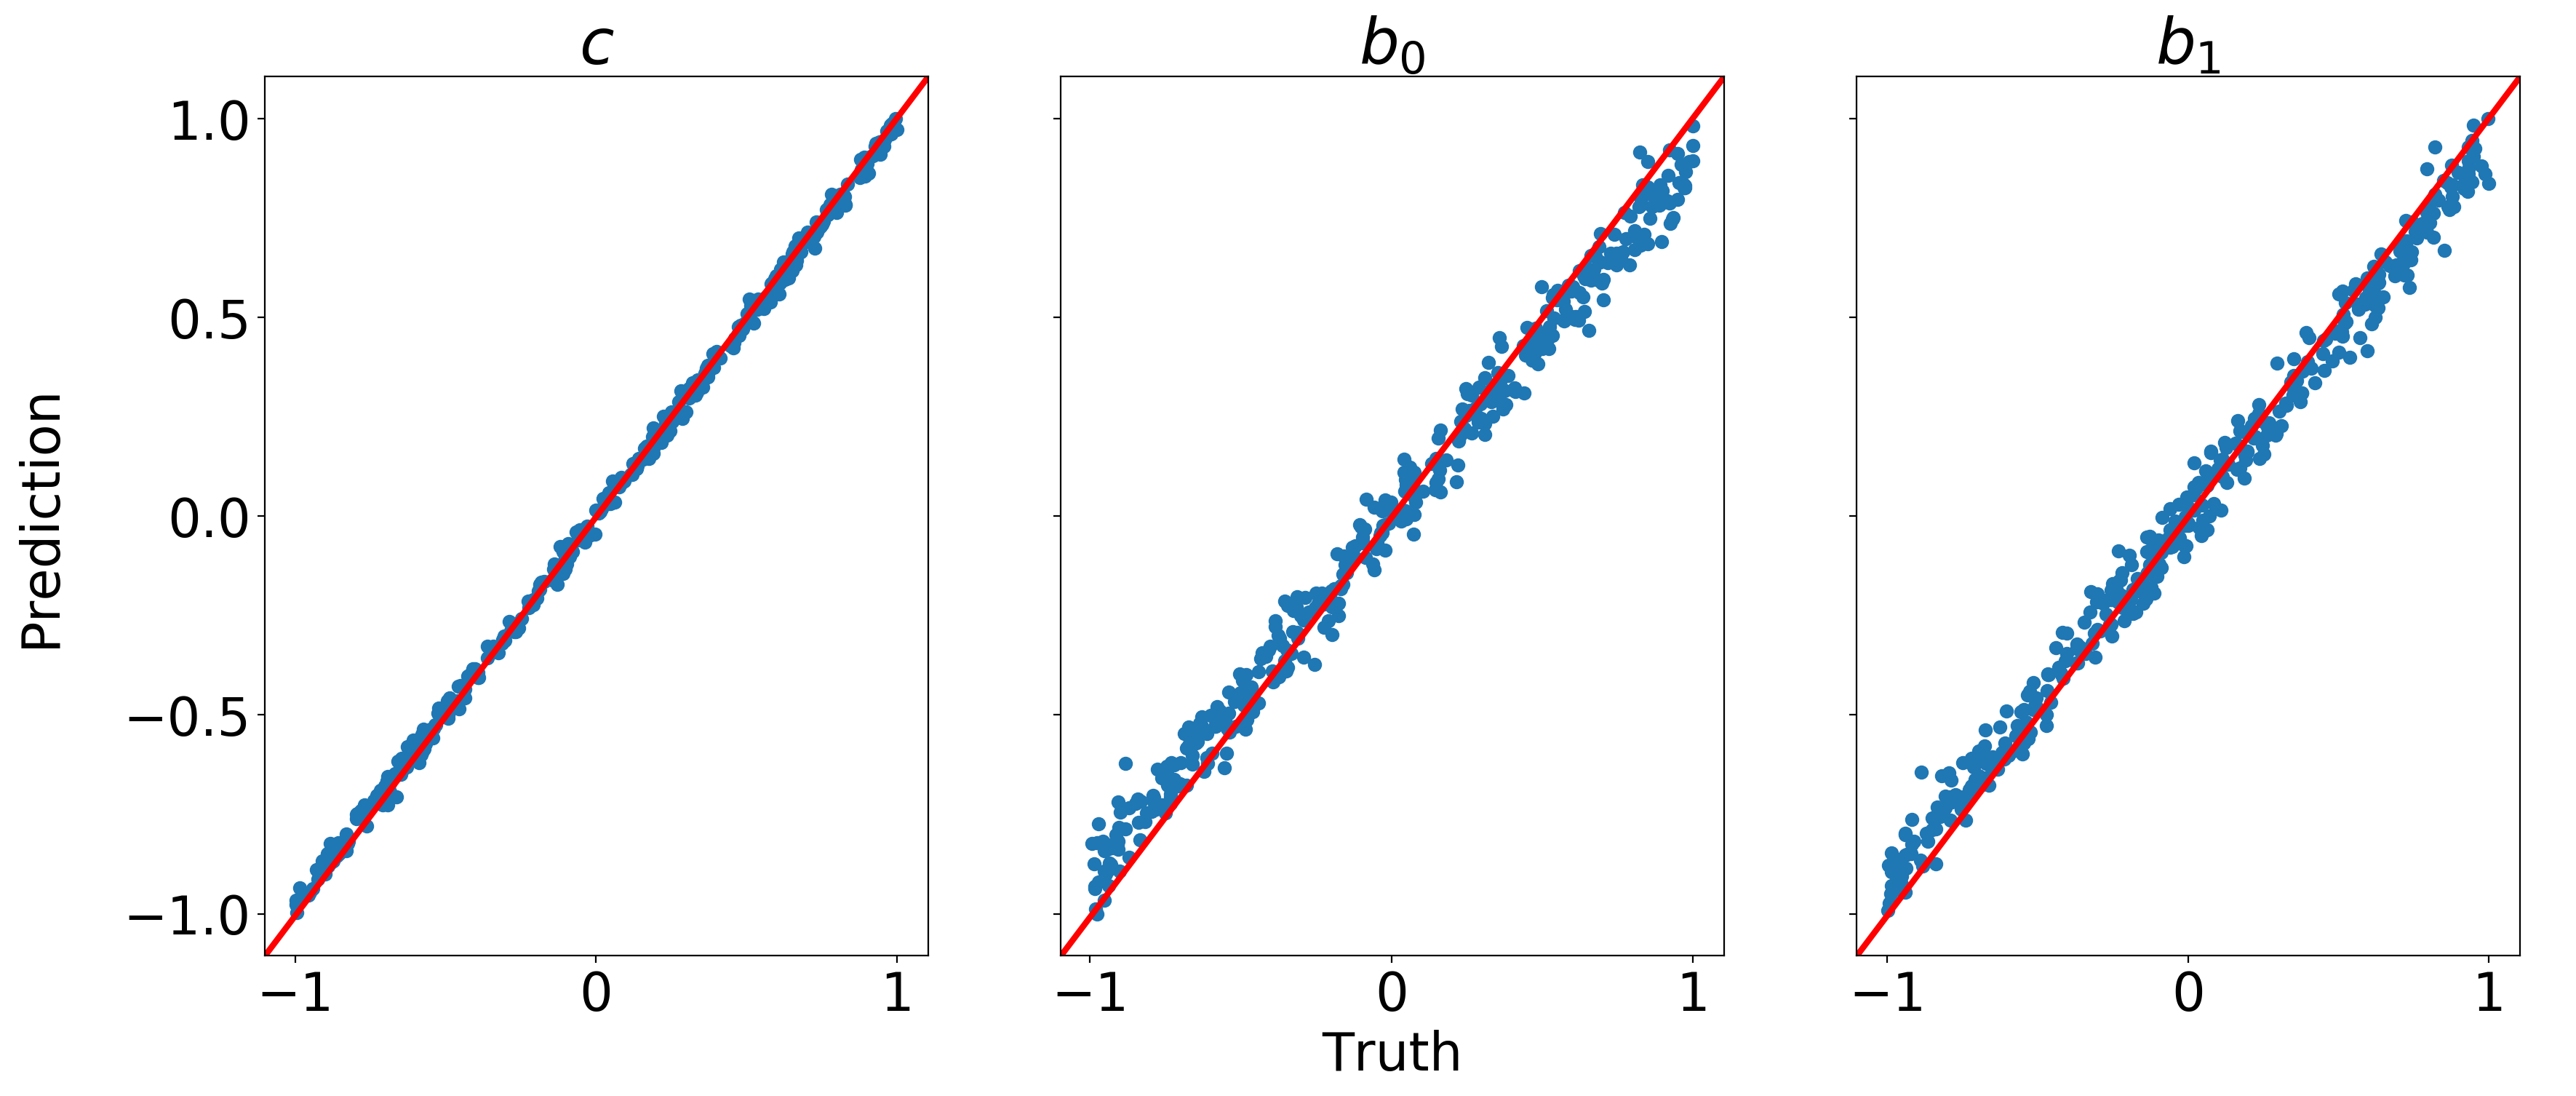

In [16]:
plot_theta(theta_test, theta_test_noisy_hat)